# Ley de Enfriamiento de Newton

In [1]:
import pandas as pd 
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns

import os
from pathlib import Path

In [2]:
from scipy.stats import linregress

In [3]:
import CoolProp.CoolProp as CP
from CoolProp.CoolProp import PropsSI

In [4]:
# Alternativa CP
# from iapws import IAPWS97
# water = IAPWS97(T=300, P=0.1)  # Temperatura en K, presión en MPa
# print(water.cp)  # kJ/kg·K
# print(water.rho)  # kg/m³

In [5]:
def newton_cooling(time, temp_env, temp_ini, k):
    temp = temp_env + (temp_ini - temp_env) * np.exp(-k * time)
    return temp

# Carga de las mediciones

In [6]:
pattern = "1_*"
base_dir = Path.cwd().parent  # Subir un nivel desde el notebook
raw_dir = base_dir / "data-lab" / "raw"
current_files = list(raw_dir.glob(pattern))
current_files_names = [file.name for file in current_files]
print(current_files_names)

['1_med-agua-calorimetro_tini-64.csv', '1_med-agua_general.csv', '1_med-agua_tini-65.csv', '1_med-agua_tini-75.csv', '1_med-agua_tini-85.csv']


In [7]:
file_labels = ['Calorimetro','General','65','75','85']
measurements = {label: pd.read_csv(file) for label,file in zip(file_labels,current_files)}
measurements['General'] = measurements['General'].set_index('Experimento')

# Visualizacion de las mediciones

In [8]:
{exp:measurements[exp].shape[0] for exp in ['65','75','85']}

{'65': 373, '75': 443, '85': 527}

In [9]:
colors = ['#B5828C','#D84040', '#A31D1D','black']

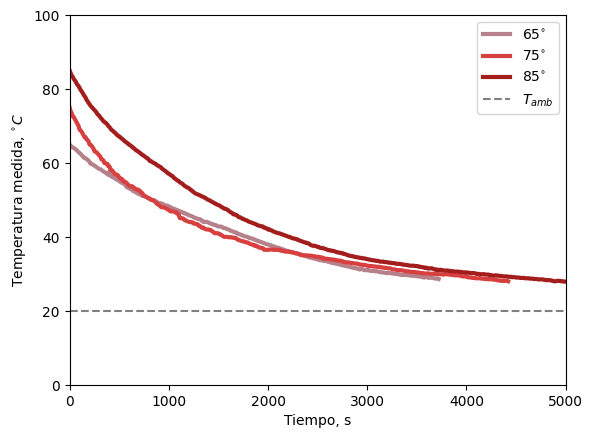

In [55]:
fig, ax = plt.subplots()
for experiment, color in zip(['65','75','85'],colors):
    measurements[experiment].plot(kind='line',x='Tiempo_s',y='Temperatura_C',color=color, lw=3,label='$' + experiment + '^{\\circ}$',ax=ax)
ax.hlines(y=20,xmin=0,xmax=5000,color='grey',ls='--',label='$T_{amb}$')
plt.legend()
ax.set_ylabel('Temperatura medida, $^{\\circ} C$')
ax.set_xlabel('Tiempo, s')
ax.set_ylim(0,100)
ax.set_xlim(0,5000)
fig.savefig('Presentacion datos.pdf',dpi=300)
plt.show()

# Linealizacion de los datos

In [11]:
point_spacing = 1

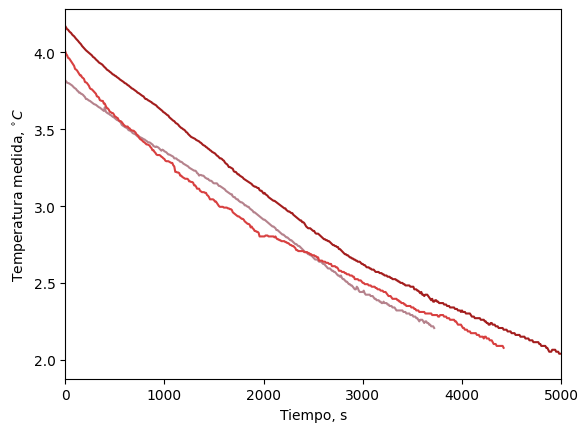

In [12]:
fig, ax = plt.subplots()
for experiment,i, color in zip(['65','75','85'],range(1,4),colors):
    y = np.log(measurements[experiment].Temperatura_C - measurements['General'].loc[i,'Tamb_C'])
    x = measurements[experiment].Tiempo_s 
    ax.plot(x[::point_spacing],y[::point_spacing],color=color)
ax.set_ylabel('Temperatura medida, $^{\\circ} C$')
ax.set_xlabel('Tiempo, s')
ax.set_xlim(0,5000)
plt.show()

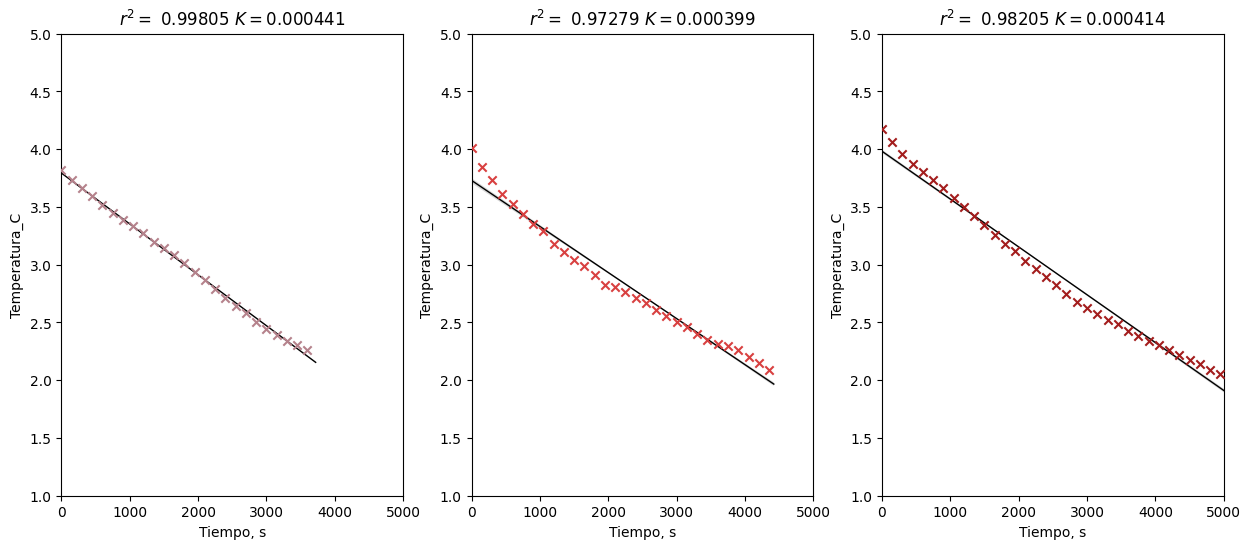

In [13]:
point_spacing = 15
fig, axes = plt.subplots(figsize=(15,6),ncols=3)
for experiment,i,color,ax in zip(['65','75','85'],range(1,4),colors,axes.ravel()):
    y = np.log(measurements[experiment].Temperatura_C - measurements['General'].loc[i,'Tamb_C'])
    x = measurements[experiment].Tiempo_s 
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    sns.regplot(x=x, y=y,scatter=False, line_kws={"color": "black", "lw": 1, "alpha":1},ax=ax)
    ax.scatter(x[::point_spacing],y[::point_spacing],color=color,marker='x',zorder=3)
    ax.set_title(round(r_value**2,5))
    ax.set_title(f'$r^2=$ {round(r_value**2,5)} $K=${-round(slope,6)}')
    ax.set_xlabel('Tiempo, s')
    ax.set_xlim(0,5000)
    ax.set_ylim(1,5)
plt.show()

## Limitacion del intervalo de datos

In [35]:
k_values = []

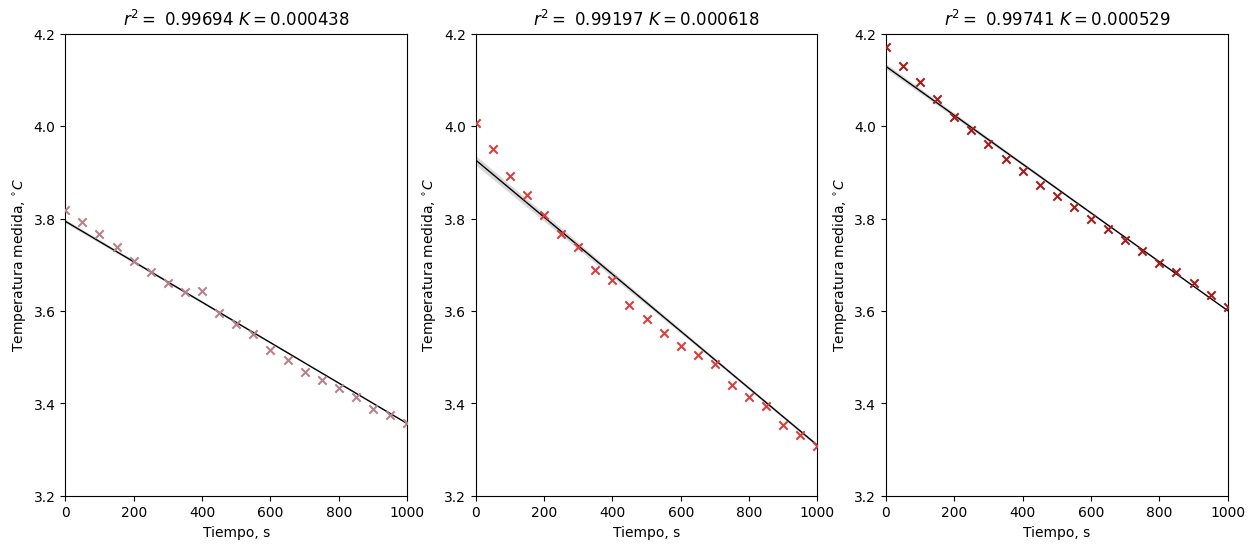

In [36]:
point_spacing = 5
until_id = 150
fig, axes = plt.subplots(figsize=(15,6),ncols=3)
for experiment,i,color,ax in zip(['65','75','85'],range(1,4),colors,axes.ravel()):
    y = np.log(measurements[experiment].Temperatura_C[:until_id] - measurements['General'].loc[i,'Tamb_C'])
    x = measurements[experiment].Tiempo_s[:until_id]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    k_values.append(slope)
    sns.regplot(x=x, y=y,scatter=False, line_kws={"color": "black", "lw": 1, "alpha":1},ax=ax)
    ax.scatter(x[::point_spacing],y[::point_spacing],color=color,marker='x',zorder=3)
    ax.set_title(f'$r^2=$ {round(r_value**2,5)} $K=${-round(slope,6)}')
    ax.set_ylabel('Temperatura medida, $^{\\circ} C$')
    ax.set_xlabel('Tiempo, s')
    ax.set_xlim(0,1000)
    ax.set_ylim(3.2,4.2)
fig.savefig('comparativa_vasos.svg',dpi=200)
plt.show()

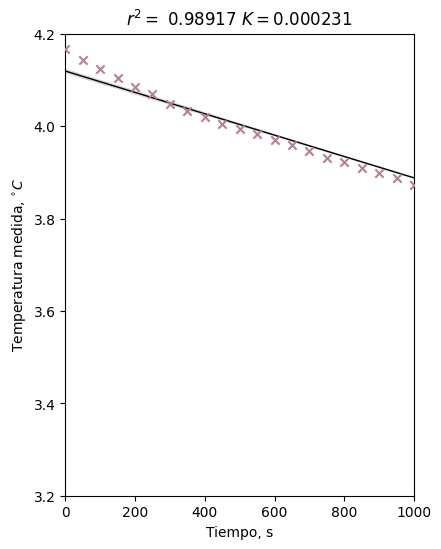

In [62]:
point_spacing = 5
until_id = 200
fig, ax = plt.subplots(figsize=(4.5,6))
for experiment,i,color in zip(['Calorimetro'],range(1,4),colors):
    y = np.log(measurements[experiment].Temperatura_C[:until_id] - measurements['General'].loc[i,'Tamb_C'])
    x = measurements[experiment].Tiempo_s[:until_id]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    # k_values.append(slope)
    sns.regplot(x=x, y=y,scatter=False, line_kws={"color": "black", "lw": 1, "alpha":1},ax=ax)
    ax.scatter(x[::point_spacing],y[::point_spacing],color=color,marker='x',zorder=3)
    ax.set_title(f'$r^2=$ {round(r_value**2,5)} $K=${-round(slope,6)}')
    ax.set_ylabel('Temperatura medida, $^{\\circ} C$')
    ax.set_xlabel('Tiempo, s')
    ax.set_xlim(0,1000)
    ax.set_ylim(3.2,4.2)
fig.savefig('calorimetro linealizacion.pdf',dpi=200)
plt.show()

In [38]:
k_values =np.array(k_values)

## Visualizacion de incertidumbres

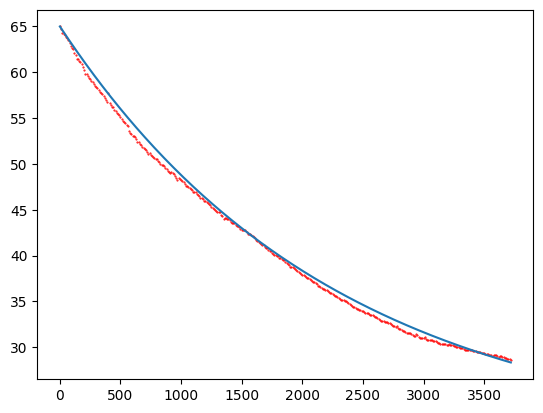

In [180]:
point_spacing = 5
y = np.log(measurements['65'].Temperatura_C - measurements['General'].loc[1,'Tamb_C'])
x = measurements['65'].Tiempo_s 
slope, intercept, r_value, p_value, std_err = linregress(x, y)
# plt.scatter(x[::point_spacing],y[::point_spacing],marker='.',s=1,color='red')
plt.scatter(x,measurements['65'].Temperatura_C,marker='.',s=1,color='red')
plt.plot(x, newton_cooling(x, measurements['General'].loc[1,'Tamb_C'], measurements['65'].Temperatura_C[0], -slope))
plt.show()

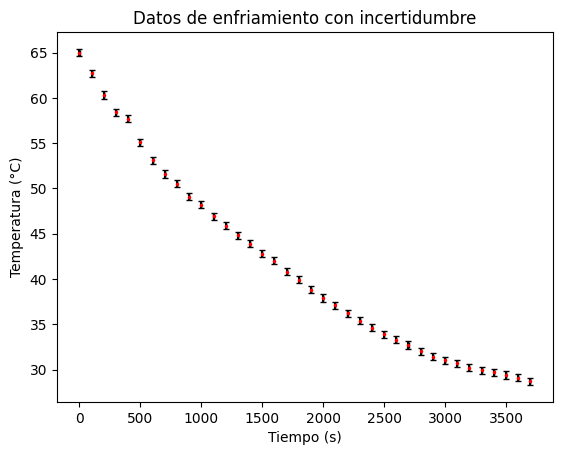

In [185]:
dt = 0.4  
dT = 0.4  

# Extraer datos
x = measurements['65'].Tiempo_s
y = measurements['65'].Temperatura_C

plt.errorbar(x[::10], y[::10], xerr=dt, yerr=dT, fmt='.', capsize=2, color='red', ecolor='black', markersize=3)

plt.xlabel("Tiempo (s)")
plt.ylabel("Temperatura (°C)")
plt.title("Datos de enfriamiento con incertidumbre")

plt.show()


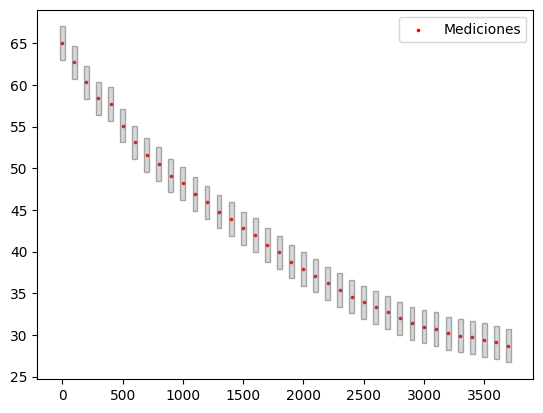

In [200]:
dt = 40  # Incertidumbre en tiempo (2 * 0.2 s)
dT = 4  # Incertidumbre en temperatura (2 * (0.1 + 0.1) °C)

# Extraer datos
x = measurements['65'].Tiempo_s
y = measurements['65'].Temperatura_C

fig, ax = plt.subplots()
ax.scatter(x[::10], y[::10], color='red', marker='.', s=10, label="Mediciones")

for xi, yi in zip(x[::10], y[::10]):
    rect = plt.Rectangle((xi - dt / 2, yi - dT / 2), dt, dT, edgecolor='black', facecolor='gray', alpha=0.3)
    ax.add_patch(rect)

plt.legend()
plt.show()


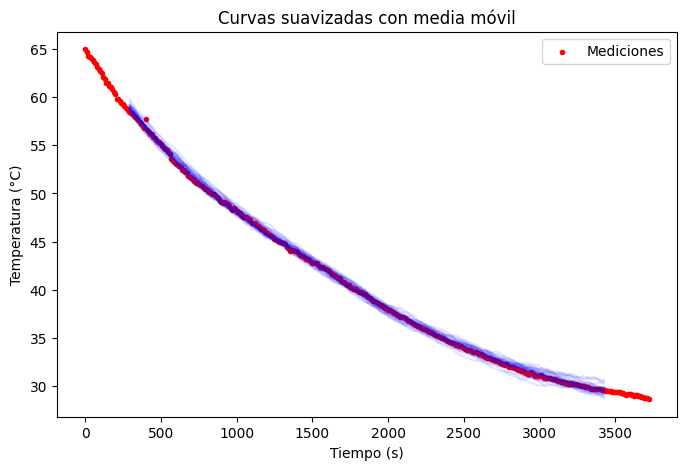

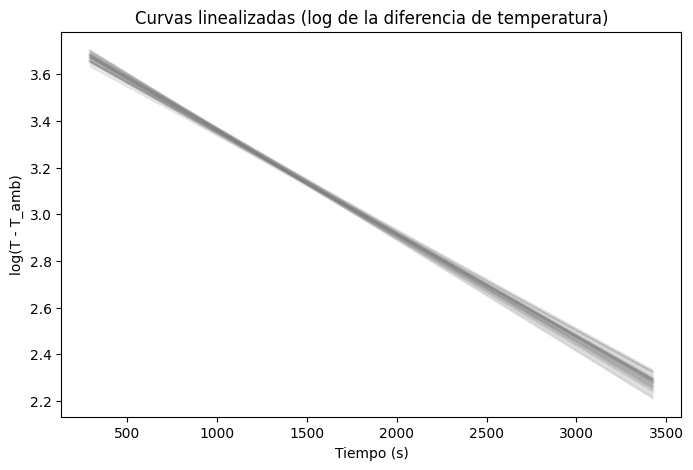

In [210]:
dt = 40  # Incertidumbre en tiempo (2 * 0.2 s)
dT = 10  # Incertidumbre en temperatura (2 * (0.1 + 0.1) °C)

x_med = measurements['65'].Tiempo_s
y_med = measurements['65'].Temperatura_C
Tamb = measurements['General'].loc[1, 'Tamb_C']  # Temperatura ambiente

num_curvas = 30
window_size = 60 

# Función de media móvil
def moving_average(arr, window):
    return np.convolve(arr, np.ones(window)/window, mode='valid')

curvas_x = []
curvas_y = []
curvas_x_log = []
curvas_y_log = []

for _ in range(num_curvas):
    x_sample = x_med + np.random.uniform(-dt/2, dt/2, size=len(x_med))
    y_sample = y_med + np.random.uniform(-dT/2, dT/2, size=len(y_med))
    
    x_smooth = moving_average(x_sample, window_size)
    y_smooth = moving_average(y_sample, window_size)
    y_log = np.log(np.maximum(y_smooth - Tamb, 1e-6))  # Asegura valores positivos
    
    curvas_x.append(x_smooth)
    curvas_y.append(y_smooth)
    curvas_x_log.append(x_smooth) 
    curvas_y_log.append(y_log)

plt.figure(figsize=(8, 5))
for i in range(num_curvas):
    plt.plot(curvas_x[i], curvas_y[i], alpha=0.1, color='blue')

plt.scatter(x_med, y_med, color='red', marker='.', label="Mediciones")

plt.xlabel("Tiempo (s)")
plt.ylabel("Temperatura (°C)")
plt.title("Curvas suavizadas con media móvil")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(num_curvas):
    # plt.plot(curvas_x_log[i], curvas_y_log[i], alpha=0.3, color='green')
    sns.regplot(x=curvas_x_log[i], y=curvas_y_log[i],scatter=False, line_kws={"color": "gray", "lw": 2, "alpha":0.1})
    
plt.xlabel("Tiempo (s)")
plt.ylabel("log(T - T_amb)")
plt.title("Curvas linealizadas (log de la diferencia de temperatura)")
plt.show()

# Calculo K teorica

## Propiedades del agua

In [39]:
# Water Properties
temperature = [20, 30, 40, 50, 60, 70, 80]
heat_capacity = [4182, 4178, 4174, 4170, 4166, 4162, 4158] # Isobaric mass heat capacity
density = [998.0, 995.7, 992.2, 988.1, 983.3, 977.8, 971.8]
labels = ['Temp','Cp','Rho']

water_properties = pd.DataFrame(zip(temperature, heat_capacity, density),columns = labels)

In [40]:
print(water_properties)

   Temp    Cp    Rho
0    20  4182  998.0
1    30  4178  995.7
2    40  4174  992.2
3    50  4170  988.1
4    60  4166  983.3
5    70  4162  977.8
6    80  4158  971.8


[Documentacion CoolProp](http://www.coolprop.org/coolprop/HighLevelAPI.html#partial-derivatives)

In [41]:
# Comparativa valores de coolprop
substance = 'Water'
atm_to_pascal = 101325
patm_cdmx_atm = 0.7643
patm_cdmx_pa = patm_cdmx_atm * atm_to_pascal
temp_k = np.linspace(20, 80, 100) + 273.15
coolprop_cp = PropsSI("CPMASS", "T", temp_k, "P", patm_cdmx_pa, substance)
coolprop_rho = PropsSI("D", "T", temp_k, "P", patm_cdmx_pa, substance)

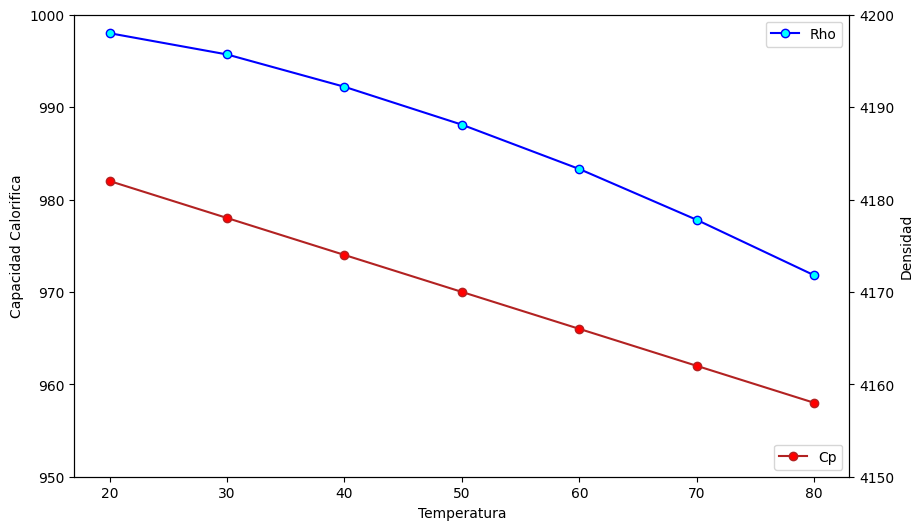

In [42]:
fig, ax = plt.subplots(figsize=(10,6))
ax2 = ax.twinx()
water_properties.plot(x='Temp',y='Rho',ls='-',marker='o',mfc='cyan',color='blue',ax=ax)
water_properties.plot(x='Temp',y='Cp',ls='-',marker='o',mfc='red',color='firebrick',ax=ax2,legend='lower')
ax.legend(loc='upper right')
ax2.legend(loc='lower right')
ax.set_ylim(950,1000)
ax2.set_ylim(4150,4200)
ax.set_ylabel('Capacidad Calorifica')
ax2.set_ylabel('Densidad')
ax.set_xlabel('Temperatura')
plt.show()

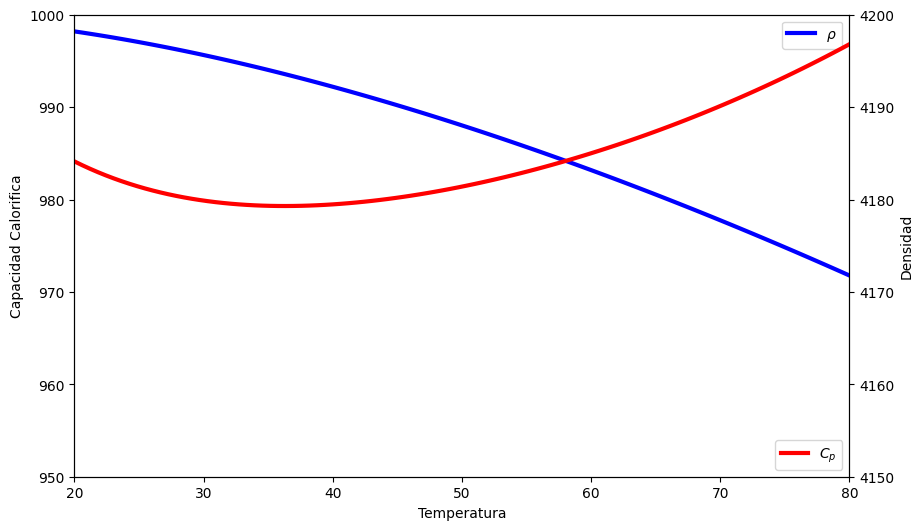

In [43]:
fig, ax = plt.subplots(figsize=(10,6))
ax2 = ax.twinx()
# water_properties.plot(x='Temp',y='Rho',ls='-',marker='o',mfc='cyan',color='blue',ax=ax)
# water_properties.plot(x='Temp',y='Cp',ls='-',marker='o',mfc='red',color='firebrick',ax=ax2,legend='lower')
ax.plot(temp_k - 273.15 , coolprop_rho,label='$\\rho$',color='blue',lw=3)
ax2.plot(temp_k - 273.15, coolprop_cp,label='$C_p$', color='red',lw=3)
ax.legend(loc='upper right')
ax2.legend(loc='lower right')
ax.set_xlim(20,80)
ax.set_ylim(950,1000)
ax2.set_ylim(4150,4200)
ax.set_ylabel('Capacidad Calorifica')
ax2.set_ylabel('Densidad')
ax.set_xlabel('Temperatura')
plt.show()

Calcular $K_{\text{teorica}}$ como:


$$
K_{Teorica} = \frac{h(T_i)* A}{\rho (T_i) C_p (T_i) V}
$$

Si a $60 ^{\circ} C$ con convección natural, 


\begin{equation}
\begin{aligned}
    h(60) &\approx 10 \quad \text{W/m}^2\text{K} \\
    \rho(60) &= 983.3 \quad \text{kg/m}^3 \\
    C_p(60) &= 4166 \quad \text{J/kgK} \\
    V &= 0.001 \quad \text{m}^3
\end{aligned}
\end{equation}

$$
\Rightarrow K_{Teorica} = \frac{10}{983.3 \times 4166 \times 0.001}
$$

Determina $\rho(T)$ y $Cp(T)$

$$
K=\frac{\mathrm{~W} / \mathrm{m}^2 \mathrm{~K}}{\left(\mathrm{~kg} / \mathrm{m}^3\right) \times( \mathrm{~J} / \mathrm{kgK}) \times\left( \mathrm{~m}^3\right)} 
=\frac{ \mathrm{~J} /\left(\mathrm{s} \cdot \mathrm{~m}^2 \mathrm{~K}\right)}{\left(\mathrm{~kg} / \mathrm{m}^3\right) \times( \mathrm{~J} / \mathrm{kgK}) \times\left( \mathrm{~m}^3\right)}
= \frac{J /\left(s \cdot m^2 K\right)}{J / K}=\frac{1}{s\cdot m^2}
$$

In [44]:
def cooling_constant(h, rho, cp, v):
    k = (h*0.0182)/(rho*cp*v)
    return k

In [45]:
ml_to_m3 = 0.000001000
nature_convection = 15 # W/(m2*K)
water_vol = 200 # mL
water_vol *= ml_to_m3

In [46]:
temp_c = [65, 75, 85, 84]
temp_kelvin = np.array(temp_c) + 273.15

cp = PropsSI("CPMASS", "T", temp_kelvin, "P", patm_cdmx_pa, "Water")
rho = PropsSI("D", "T", temp_kelvin, "P", patm_cdmx_pa, "Water")
k_newton = lambda rho,cp : cooling_constant(rho=rho,cp=cp,h=nature_convection, v=water_vol)
k_theory = k_newton(rho, cp)

In [47]:
k_theory

array([0.00033245, 0.00033393, 0.00033547, 0.00033532])

In [48]:
-k_values

array([0.00043781, 0.00061793, 0.00052889, 0.00023124])

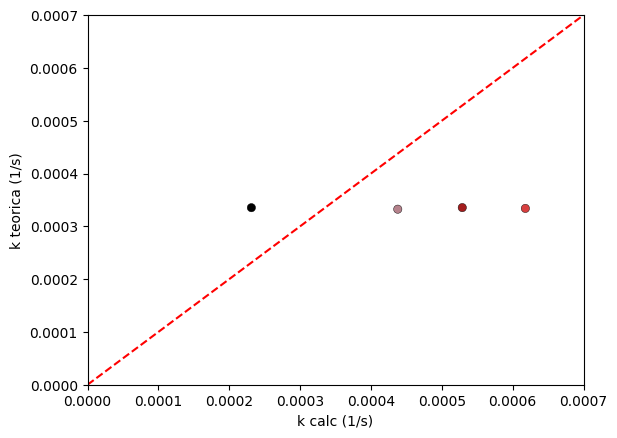

In [49]:
plt.scatter(-k_values,k_theory,c=colors,edgecolor='black',lw=0.3)
plt.axline((0, 0), slope=1, linestyle="--", color="red", label="45° Line")
plt.xlim(0,0.0007)
plt.ylim(0,0.0007)
plt.ylabel('k teorica (1/s)')
plt.xlabel('k calc (1/s)')
plt.show()

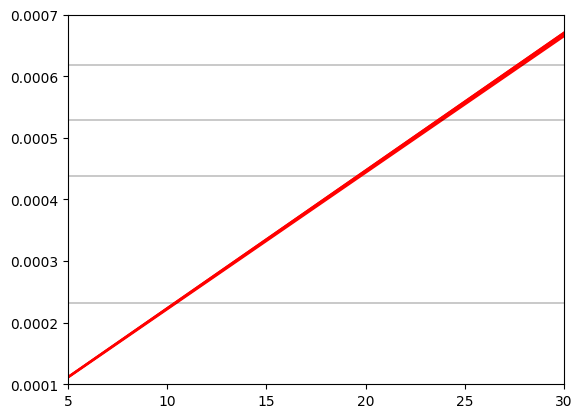

In [50]:
h_range = np.linspace(5,30,100)
fig, ax = plt.subplots()
for temp,k in zip([65,75,85,84],-k_values):
    k_range = cooling_constant(h =h_range,
                               cp = PropsSI("CPMASS", "T", temp + 273.15, "P", patm_cdmx_pa, "Water"),
                               rho = PropsSI("D", "T", temp + 273.15, "P", patm_cdmx_pa, "Water"),
                               v=200*ml_to_m3)
    ax.hlines(y=k,xmin= 5, xmax=30,color='black',lw=0.3)  
    ax.plot(h_range,k_range,color='red')
ax.set_ylim(0.0001,0.0007)
ax.set_xlim(5,30)
plt.show()

# Calculo T a partir de K calculada

In [51]:
measurements['65'].Tiempo_s.diff().mean()

np.float64(10.0)

In [52]:
{exp:float(measurements[exp].Tiempo_s.max()) for exp in ['65','75','85']}

{'65': 3720.0, '75': 4420.0, '85': 5260.0}

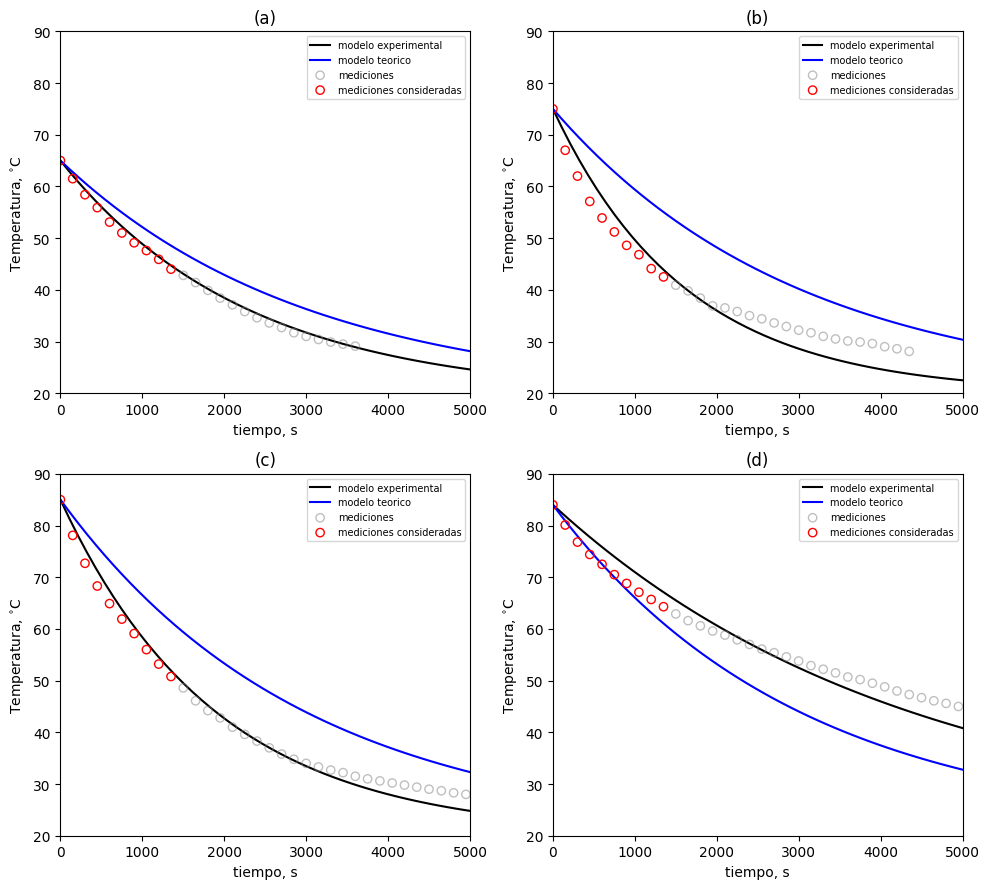

In [54]:
point_spacing = 15
until_id = 150
times_s = np.linspace(0,5260.0)  
titles = ['(a)','(b)','(c)','(d)']
fig, axes = plt.subplots(figsize=(10,9),ncols=2, nrows=2)
for experiment,i,color,title,ax in zip(['65','75','85','Calorimetro'],range(1,5),colors,titles,axes.ravel()):
    temp_i = newton_cooling(times_s, measurements['General'].loc[i,'Tamb_C'],measurements[experiment].Temperatura_C[0],-k_values[i-1])
    temp_j = newton_cooling(times_s, measurements['General'].loc[i,'Tamb_C'],measurements[experiment].Temperatura_C[0],k_theory[i-1])
    ax.plot(times_s, temp_i,color='black',zorder=0,label='modelo experimental')
    ax.plot(times_s, temp_j,color='blue',zorder=0,label='modelo teorico')
    ax.scatter(measurements[experiment].Tiempo_s.values[until_id::point_spacing], 
               measurements[experiment].Temperatura_C.values[until_id::point_spacing],
              c='none',edgecolor='gray',alpha=0.5,label='mediciones')
    ax.scatter(measurements[experiment].Tiempo_s.values[:until_id:point_spacing], 
               measurements[experiment].Temperatura_C.values[:until_id:point_spacing],
              c='none',edgecolor='red',label='mediciones consideradas')
    ax.legend(fontsize=7)
    ax.set_xlim(0,5000)
    ax.set_ylim(20,90)
    ax.set_ylabel('Temperatura, $^{\\circ}$C')
    ax.set_xlabel('tiempo, s')
    ax.set_title(title)
plt.tight_layout()
fig.savefig('Resultados Comparativa.pdf',dpi=300)
plt.show()

# Resultados

In [318]:
results = pd.DataFrame(zip(temp_c,k_theory ,-k_values), columns = ['Temp_C','k_teorica','k_calc'])
results['err'] = 100*np.abs(results.k_teorica-results.k_calc)/results.k_teorica

In [319]:
print(results)

   Temp_C  k_teorica    k_calc        err
0      65   0.000332  0.000438  31.693124
1      75   0.000334  0.000618  85.048118
2      85   0.000335  0.000529  57.654041
3      84   0.000335  0.000231  31.037810


## Salida Figuras

In [353]:
# base_dir = Path.cwd().parent  # Subir un nivel desde el notebook
# data_dir = base_dir / "data"
# final_dir = data_dir / "final"
# subfolder = final_dir / "1_enfriamiento"  # Carpeta específica dentro de final/

# # Crear la carpeta si no existe
# subfolder.mkdir(parents=True, exist_ok=True)

# # Mostrar ruta creada
# print(f"Archivos serán guardados en: {subfolder}")

# # -------- Ejemplo: Guardar un CSV en 1_enfriamiento --------
# df = pd.DataFrame({"Temperatura": [20, 18, 15, 10], "Tiempo": [0, 10, 20, 30]})
# df.to_csv(subfolder / "datos_enfriamiento.csv", index=False)

# # -------- Ejemplo: Guardar una imagen en 1_enfriamiento --------
# plt.plot(df["Tiempo"], df["Temperatura"], marker="o")
# plt.xlabel("Tiempo (min)")
# plt.ylabel("Temperatura (°C)")
# plt.title("Curva de Enfriamiento")

# # Guardar imagen en la carpeta creada
# img_path = subfolder / "curva_enfriamiento.png"
# plt.savefig(img_path, dpi=300, bbox_inches="tight")

# print(f"Imagen guardada en: {img_path}")


- Errores de mediciones: debido a corrientes de aire
-analizando los datos obtenidos con ayuda de herramientas estadisticas pudimos obsrvar dos situaciones:
Las condiciones del entorno que suopone el modelo de enfriamento de newton no se cumplen, debido a un cambio en las temperatura ambiente y a la presencia de rafagas de viento alrededor de nuestro sistema lo que complica
- De acuerdo a la ec X, la k constituye  una relacion directa con h, la constante de conveccion, la cual tiene un valor incierto para las condiciones experimentales, y tiene un rango de 5 a 25, lo que imposibilita tener un valor teorico que usar para la comparacion de la k experimental. 